# Importing required packages

In [1]:
# File navigation
import os

# Measuring run time
from time import time
import pyprind
from tqdm import tqdm

# Data manipulation/analysis
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import islice
%matplotlib inline

# Modelling
import tensorflow as tf
from sklearn.metrics import classification_report

# Data partitioning
from sklearn.model_selection import train_test_split

# Text preprocessing/analysis
import io
import re, random
import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from symspellpy import SymSpell, Verbosity

tqdm.pandas()

nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Converting .txt files to .csv

### Training Data

In [2]:
labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000) # progress bar
train_df = pd.DataFrame()

for y in ('pos', 'neg'):
    path = f"train/{y}" # iterate through train folder, adding both pos and neg reviews to dataframe
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
            txt = infile.read()
        train_df = train_df.append([[txt, labels[y]]], ignore_index=True) # add current review to dataframe
        pbar.update()

train_df.columns = ['review', 'sentiment'] # columns of csv file

train_df.to_csv('train.csv', index=False, encoding='utf-8') # save combined training data to csv

0% [###############               ] 100% | ETA: 00:04:02

In [3]:
train_df = pd.read_csv("train.csv")

In [4]:
train_df.head()

,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


### Test Data

In [5]:
labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000) # progress bar
test_df = pd.DataFrame()

for y in ('pos', 'neg'):
    path = f"test/{y}" # iterate through test folder, adding both pos and neg reviews to dataframe
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
            txt = infile.read()
        test_df = test_df.append([[txt, labels[y]]], ignore_index=True) # add current review to dataframe
        pbar.update()

test_df.columns = ['review', 'sentiment'] # columns of csv file

test_df.to_csv('test.csv', index=False, encoding='utf-8') # save combined test data to csv

0% [###############               ] 100% | ETA: 00:03:56

In [6]:
test_df = pd.read_csv("test.csv")

In [7]:
test_df.head()

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


# Text Preprocessing

## Preprocessing Functions

In [8]:
# Strip trailing whitespaces
def strip(text):
    return text.strip()

# Remove <br> html tags
def remove_brs(text):
    return text.replace('<br />', ' ').replace('<br />', ' ')

# Remove duplicate consecutive whitespacves
def remove_multi_spaces(text):
    return " ".join(text.split())

# Convert text to a list of tokens
def tokenize(text):
    return nltk.tokenize.word_tokenize(text)

# Keep alphabetical characters only
def keep_text(text):
    pattern = r'[^a-zA-z\s]'
    result = re.sub(pattern, ' ', text)
    return result

# Convert text to lower case
def lower_case(text):
    return text.lower()

# lemmatise text to its stem (in dictionary)
def lemmatize(text):
    wn = nltk.WordNetLemmatizer()
    result = wn.lemmatize(text)
    return result

# List of contractions
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Query contraction's full form from dictionary
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

# Replacement contraction with its full form
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [9]:
# Preprocessing function that is to be applied to review column
def preprocess(text):
    result = remove_brs(text)
    result = replace_contractions(result)
    result = strip(result)
    result = lower_case(result)
    result = remove_multi_spaces(result)
    result = keep_text(result)
    result = lemmatize(result)
    result = tokenize(result)
    result = ' '.join(result)
    return result

## Preprocessing on Training Data

In [10]:
pbar = pyprind.ProgBar(50000)

train_df['review'] = train_df['review'].progress_apply(preprocess) # Preprocess training data

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:45<00:00, 549.83it/s]


In [11]:
def spellcheck(word):
    return sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)[0]._term # if mispelt, return closest correct word

train_dict = {}

# Populate dictionary of word frequencies in training corpus
for row in train_df['review']:
    for word in row.split():
        if word not in train_dict:
            train_dict[word] = 1
        else:
            train_dict[word] += 1

# Write dictionary to a text file (for SymSpell to load later on)
with open('train_dict.txt', 'w') as file:
    for key, value in train_dict.items():
        file.write(f"{key} {value}\n")

# Initialise SymSpell object and load text file of dictionary
sym_spell = SymSpell()
sym_spell.load_dictionary("train_dict.txt", 0, 1)

# Apply spellcheck on training data's review column
train_df['review'] = train_df['review'].progress_apply(lambda x: ' '.join([spellcheck(i) for i in x.split()]))

100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:20<00:00, 1248.76it/s]


In [12]:
train_df.to_csv('train_preprocessed.csv', index=False, encoding='utf-8') # save preprocessed training data to csv

In [13]:
train_df = pd.read_csv('train_preprocessed.csv')
train_df.head()

,review,sentiment
0,bromwell high is a cartoon comedy it ran at th...,1
1,homelessness or houselessness as george carlin...,1
2,brilliant over acting by lesley ann warren bes...,1
3,this is easily the most underrated film inn th...,1
4,this is not the typical mel brooks film it was...,1


## Preprocessing on Test Data

In [14]:
pbar = pyprind.ProgBar(50000)

test_df['review'] = test_df['review'].progress_apply(preprocess) # Preprocess test data

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:42<00:00, 594.55it/s]


In [15]:
test_dict = {}

# Populate dictionary of word frequencies in test corpus
for row in test_df['review']:
    for word in row.split():
        if word not in test_dict:
            test_dict[word] = 1
        else:
            test_dict[word] += 1
            
# Write dictionary to a text file (for SymSpell to load later on)
with open('test_dict.txt', 'w') as file:
    for key, value in test_dict.items():
        file.write(f"{key} {value}\n")

# Initialise SymSpell object and load text file of dictionary
sym_spell = SymSpell()
sym_spell.load_dictionary("test_dict.txt", 0, 1)

# Apply spellcheck on test data's review column
test_df['review'] = test_df['review'].progress_apply(lambda x: ' '.join([spellcheck(i) for i in x.split()]))

100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:19<00:00, 1275.33it/s]


In [16]:
test_df.to_csv('test_preprocessed.csv', index=False, encoding='utf-8') # save preprocessed test data to csv

In [17]:
test_df = pd.read_csv('test_preprocessed.csv')
test_df.head()

,review,sentiment
0,i went and saw this movie last night after bei...,1
1,actor turned director bill paxton follows up h...,1
2,as a recreational golfer with some knowledge o...,1
3,i saw this film in a sneak preview and it is d...,1
4,bill paxton has taken the true story of the us...,1


# Building the Neural Network

## Method 1: Word Indexing
Takes each word in the text and replaces it with its corresponding integer value from the train_tokenizer dictionary

In [19]:
vocab = set(" ".join(train_df['review']).split()) # create set of unique words in corpus

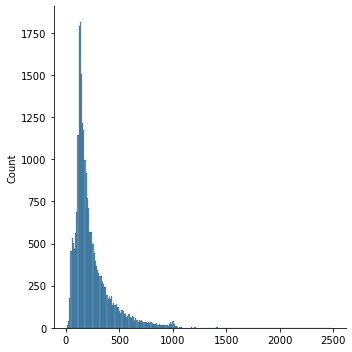

In [20]:
# Analyse distribution of review length to decide max_length of sequence padding
lengths = [len(s) for s in train_df['review'].str.split()]
sns.displot(lengths)

### Encoding Training Data

In [21]:
# Create the tokenizer
train_tokenizer = tf.keras.preprocessing.text.Tokenizer()

# Fit the tokenizer on the training documents
train_tokenizer.fit_on_texts(train_df['review'].str.split())

# Sequence encode
train_encoded_docs = train_tokenizer.texts_to_sequences(train_df['review'].str.split())

# Pad sequences
max_length = 1000
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_encoded_docs, maxlen=max_length, padding='post')

# Define vocabulary size (largest integer value)
vocab_size = len(train_tokenizer.word_index) + 1

### Encoding Test Data

In [22]:
# Sequence encode
test_encoded_docs = train_tokenizer.texts_to_sequences(test_df['review'].str.split())

# Pad sequences
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_encoded_docs, maxlen=max_length, padding='post')

### Build Word Indexing Model

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length)) # transforms words into their word embeddings
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu')) # summarizes detected features in input
model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) # highlights most present features in feature map
model.add(tf.keras.layers.Flatten()) # convert feature map to single column
model.add(tf.keras.layers.Dense(10, activation='relu')) # output the input directly if positive. otherwise, output zero
model.add(tf.keras.layers.Dropout(0.4)) # randomly ignore some units to reduce overfitting
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # output a value between 0-1 (1: pos sentiment, 0: neg sentiment)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         7343400   
_________________________________________________________________
conv1d (Conv1D)              (None, 993, 32)           25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 496, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 15872)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                158730    
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

### Create Callback Functions

In [24]:
# If val_loss hasn't decreased for 10 epochs, model training stops (to save time if it's not improving)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Saves the best model so far (in terms of val_loss) to be used later for testing
mc = tf.keras.callbacks.ModelCheckpoint('./saved_models/best_tokenizer_model', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

### Train Word Indexing Model

In [25]:
# Compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit network, with validation testing using 80-20 split and random shuffling
history = model.fit(X_train, train_df['sentiment'], epochs=30, verbose=2, validation_split=0.2, shuffle=True, callbacks=[es,mc])

Epoch 1/30
625/625 - 113s - loss: 0.4937 - accuracy: 0.7832 - val_loss: 0.7124 - val_accuracy: 0.8394

Epoch 00001: val_loss improved from inf to 0.71245, saving model to ./models\best_tokenizer_model
INFO:tensorflow:Assets written to: ./models\best_tokenizer_model\assets
Epoch 2/30
625/625 - 109s - loss: 0.3063 - accuracy: 0.9084 - val_loss: 0.6871 - val_accuracy: 0.8544

Epoch 00002: val_loss improved from 0.71245 to 0.68713, saving model to ./models\best_tokenizer_model
INFO:tensorflow:Assets written to: ./models\best_tokenizer_model\assets
Epoch 3/30
625/625 - 105s - loss: 0.1951 - accuracy: 0.9393 - val_loss: 0.7900 - val_accuracy: 0.8444

Epoch 00003: val_loss did not improve from 0.68713
Epoch 4/30
625/625 - 105s - loss: 0.1377 - accuracy: 0.9567 - val_loss: 0.8870 - val_accuracy: 0.8532

Epoch 00004: val_loss did not improve from 0.68713
Epoch 5/30
625/625 - 107s - loss: 0.1051 - accuracy: 0.9691 - val_loss: 1.3919 - val_accuracy: 0.7942

Epoch 00005: val_loss did not improve f

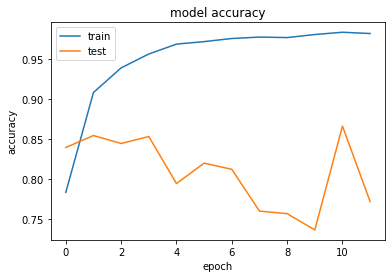

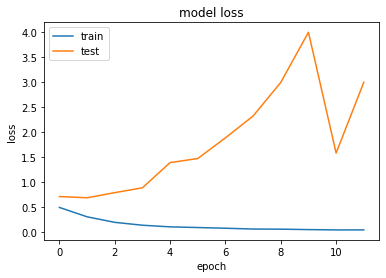

In [26]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
# Load best term frequency model
model = tf.keras.models.load_model('saved_models/best_tokenizer_model')

In [28]:
# Predicted sigmoid outputs (float between 0 and 1)
y_pred = model.predict(X_test)

# Try different classification thresholds and compare classification metrics
for threshold in [0.3, 0.5, 0.7]:
    print(f"===== Threshold: {threshold} =====\n")
    y_pred_labels = [1 if i > threshold else 0 for i in y_pred]
    print(classification_report(test_df['sentiment'], y_pred_labels))

===== Threshold: 0.3 =====

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12500
           1       0.50      1.00      0.67     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000

===== Threshold: 0.5 =====

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

===== Threshold: 0.7 =====



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.84      0.90      0.87     12500
           1       0.89      0.83      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.86     25000
weighted avg       0.87      0.86      0.86     25000



## Method 2: Word2Vec (IMDB Trained)

### Converting Text into Word2Vec (IMDB) Embeddings

In [29]:
# Train word2vec model with 100 dimensions, max distance of 5 between current and predicted word, ignoring words with freq < 1
model = Word2Vec(train_df['review'].str.split(), size=100, window=5, workers=8, min_count=1)

# Summarize vocabulary size in model
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

# Save model in ASCII (word2vec) format
filename = 'imdb_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

Vocabulary size: 73433


In [30]:
# Load embedding as a dict
def load_embedding(filename):
    # Load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    
    # Create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # Key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

In [31]:
# Create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # Total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # Define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # Step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

In [32]:
# load embedding from file
raw_embedding = load_embedding('imdb_word2vec.txt')

# Get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, train_tokenizer.word_index)

# Create the embedding layer
embedding_layer = tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

### Build IMDB Trained Word2Vec Model

In [33]:
model = tf.keras.Sequential()
model.add(embedding_layer) # transforms words into their word embeddings
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')) # summarizes detected features in input
model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) # highlights most present features in feature map
model.add(tf.keras.layers.Flatten()) # convert feature map to single column
model.add(tf.keras.layers.Dropout(0.4)) # randomly ignore some units to reduce overfitting
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # output a value between 0-1 (1: pos sentiment, 0: neg sentiment)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         7343400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 498, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 63744)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63744)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 63745     
Total params: 7,471,273
Trainable params: 127,873
Non-trainable params: 7,343,400
______________________________________

### Create Callback Functions

In [34]:
# If val_loss hasn't decreased for 10 epochs, model training stops (to save time if it's not improving)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Saves the best model so far (in terms of val_loss) to be used later for testing
mc = tf.keras.callbacks.ModelCheckpoint('./saved_models/best_imdb_w2v_model', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

### Train Word2Vec (IMDB) Model

In [35]:
# Compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit network, with validation testing using 80-20 split and random shuffling
history = model.fit(X_train, train_df['sentiment'], epochs=30, verbose=2, validation_split=0.2, shuffle=True, callbacks=[es,mc])

Epoch 1/30
625/625 - 111s - loss: 0.5711 - accuracy: 0.7246 - val_loss: 0.8239 - val_accuracy: 0.5652

Epoch 00001: val_loss improved from inf to 0.82391, saving model to ./models\best_imdb_w2v_model
INFO:tensorflow:Assets written to: ./models\best_imdb_w2v_model\assets
Epoch 2/30
625/625 - 109s - loss: 0.3702 - accuracy: 0.8422 - val_loss: 0.4130 - val_accuracy: 0.8236

Epoch 00002: val_loss improved from 0.82391 to 0.41301, saving model to ./models\best_imdb_w2v_model
INFO:tensorflow:Assets written to: ./models\best_imdb_w2v_model\assets
Epoch 3/30
625/625 - 109s - loss: 0.3004 - accuracy: 0.8741 - val_loss: 0.3954 - val_accuracy: 0.8370

Epoch 00003: val_loss improved from 0.41301 to 0.39536, saving model to ./models\best_imdb_w2v_model
INFO:tensorflow:Assets written to: ./models\best_imdb_w2v_model\assets
Epoch 4/30
625/625 - 109s - loss: 0.2551 - accuracy: 0.8931 - val_loss: 0.6106 - val_accuracy: 0.7702

Epoch 00004: val_loss did not improve from 0.39536
Epoch 5/30
625/625 - 108s

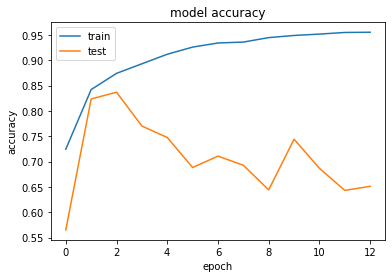

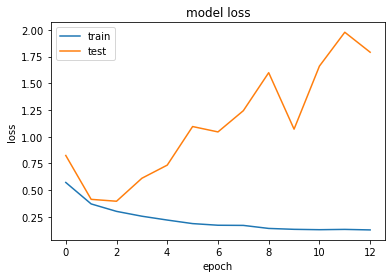

In [36]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
# Load best model
model = tf.keras.models.load_model('saved_models/best_imdb_w2v_model')

In [38]:
# Predicted sigmoid outputs (float between 0 and 1)
y_pred = model.predict(X_test)

# Try different classification thresholds and compare classification metrics
for threshold in [0.3, 0.5, 0.7]:
    print(f"===== Threshold: {threshold} =====\n")
    y_pred_labels = [1 if i > threshold else 0 for i in y_pred]
    print(classification_report(test_df['sentiment'], y_pred_labels))

===== Threshold: 0.3 =====

              precision    recall  f1-score   support

           0       0.86      0.74      0.79     12500
           1       0.77      0.88      0.82     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

===== Threshold: 0.5 =====

              precision    recall  f1-score   support

           0       0.80      0.84      0.82     12500
           1       0.83      0.80      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

===== Threshold: 0.7 =====

              precision    recall  f1-score   support

           0       0.73      0.91      0.81     12500
           1       0.88      0.67      0.76     12500

    accuracy                           0.79     25000
   macro avg       0.81      0.79      0.79 

## Method 3: Word2Vec (GloVe)

### Converting Text into Word2Vec (GloVe) Embeddings
You may download glove.6B.100d.txt file from http://nlp.stanford.edu/data/glove.6B.zip and place it in the same directory as this notebook

In [39]:
# Create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix_glove(embedding, vocab):
    # Total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # Define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # Step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        try:
            embedding_vector = embedding[word]
            if embedding_vector is not None: # if word not in GloVe vocabulary
                weight_matrix[i] = embedding_vector
        except:
            pass
    return weight_matrix

In [40]:
# Load embedding from file
raw_embedding = {}
glove_data = 'glove.6B.100d.txt'
f = open(glove_data, encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    raw_embedding[word] = coefs
f.close()

# Get vectors in the right order
embedding_vectors = get_weight_matrix_glove(raw_embedding, train_tokenizer.word_index)

# Create the embedding layer
embedding_layer = tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

### Build Word2Vec (GloVe) Model

In [41]:
# Define model
model = tf.keras.Sequential()
model.add(embedding_layer) # transforms words into their word embeddings
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')) # summarizes detected features in input
model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) # highlights most present features in feature map
model.add(tf.keras.layers.Flatten()) # convert feature map to single column
model.add(tf.keras.layers.Dropout(0.4)) # randomly ignore some units to reduce overfitting
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # output a value between 0-1 (1: pos sentiment, 0: neg sentiment)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         7343400   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 498, 128)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 63744)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 63744)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 63745     
Total params: 7,471,273
Trainable params: 127,873
Non-trainable params: 7,343,400
______________________________________

### Create Callback Functions

In [42]:
# If val_loss hasn't decreased for 10 epochs, model training stops (to save time if it's not improving)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Saves the best model so far (in terms of val_loss) to be used later for testing
mc = tf.keras.callbacks.ModelCheckpoint('./saved_models/best_glove_w2v_model', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

### Train Word2Vec (GloVe) Model

In [43]:
# Compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit network, with validation testing using 80-20 split and random shuffling
history = model.fit(X_train, train_df['sentiment'], epochs=30, verbose=2, validation_split=0.2, shuffle=True, callbacks=[es,mc])

Epoch 1/30
625/625 - 110s - loss: 0.5264 - accuracy: 0.7419 - val_loss: 0.4279 - val_accuracy: 0.7978

Epoch 00001: val_loss improved from inf to 0.42789, saving model to ./models\best_glove_w2v_model
INFO:tensorflow:Assets written to: ./models\best_glove_w2v_model\assets
Epoch 2/30
625/625 - 109s - loss: 0.3795 - accuracy: 0.8346 - val_loss: 0.4711 - val_accuracy: 0.7674

Epoch 00002: val_loss did not improve from 0.42789
Epoch 3/30
625/625 - 109s - loss: 0.3126 - accuracy: 0.8670 - val_loss: 0.4102 - val_accuracy: 0.8266

Epoch 00003: val_loss improved from 0.42789 to 0.41019, saving model to ./models\best_glove_w2v_model
INFO:tensorflow:Assets written to: ./models\best_glove_w2v_model\assets
Epoch 4/30
625/625 - 109s - loss: 0.2516 - accuracy: 0.8982 - val_loss: 0.4642 - val_accuracy: 0.7856

Epoch 00004: val_loss did not improve from 0.41019
Epoch 5/30
625/625 - 109s - loss: 0.1975 - accuracy: 0.9219 - val_loss: 0.9747 - val_accuracy: 0.6318

Epoch 00005: val_loss did not improve f

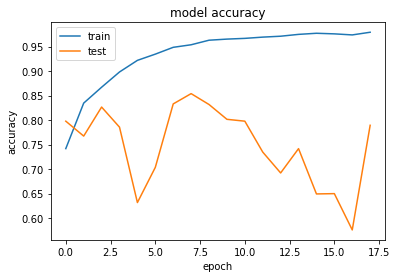

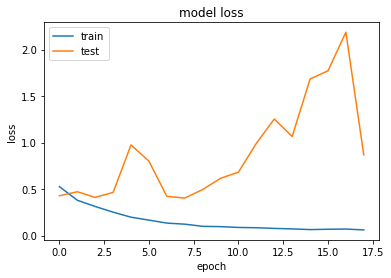

In [44]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
# Load best model
model = tf.keras.models.load_model('saved_models/best_glove_w2v_model')

In [46]:
# Predicted sigmoid outputs (float between 0 and 1)
y_pred = model.predict(X_test)

# Try different classification thresholds and compare classification metrics
for threshold in [0.3, 0.5, 0.7]:
    print(f"===== Threshold: {threshold} =====\n")
    y_pred_labels = [1 if i > threshold else 0 for i in y_pred]
    print(classification_report(test_df['sentiment'], y_pred_labels))

===== Threshold: 0.3 =====

              precision    recall  f1-score   support

           0       0.84      0.79      0.82     12500
           1       0.80      0.85      0.83     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

===== Threshold: 0.5 =====

              precision    recall  f1-score   support

           0       0.80      0.86      0.83     12500
           1       0.85      0.79      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000

===== Threshold: 0.7 =====

              precision    recall  f1-score   support

           0       0.76      0.90      0.82     12500
           1       0.88      0.71      0.79     12500

    accuracy                           0.81     25000
   macro avg       0.82      0.81      0.81 

# References

Text Preprocessing in Python: Steps, Tools, and Examples<br>
https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908

NLP Learning Series: Part 1 - Text Preprocessing Methods for Deep Learning<br>
https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/

Progress Bars in Python<br>
https://towardsdatascience.com/progress-bars-in-python-4b44e8a4c482

symspellpy Spellcheck Tutorial<br>
https://symspellpy.readthedocs.io/en/latest/examples/lookup.html#basic-usage

How to Prepare Text Data for Deep Learning with Keras<br>
https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model<br>
https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92

Basics of Using Pre-trained GloVe Vectors in Python<br>
https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db

Gensim Word2Vec Tutorial<br>
https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

Deep Convolutional Neural Network for Sentiment Analysis (Text Classification)<br>
https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

Use Early Stopping to Halt the Training of Neural Networks At the Right Time<br>
https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/